In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# read data
df = pd.read_csv('../data/Test/unwinded_merged_OVS_2016-19.csv')
with open('../data/Test/label_map.json', 'r') as json_file:
    label_map = json.load(json_file)

/tmp/ipykernel_1596/708755072.py:2: DtypeWarning: Columns (13,20,23,26,37,40,46,59,62,67,70,90,109,111,113,115,117,120,122,125,132,139,145,147,149,154,159,161,170,176,181,183,185,187,189,191,193,209,215,220,222,224,226,228,232,234,237,239,256,259,262,287,291,303,307,327,340,344,364,399,406,420,430,441,454,481,491,496,512,519,525,543,547,551,674,706,758,764,768,773,777,781,786,804,806,808,983,1005,1006,1007,1009,1121,1123,1126,1127,1130,1131,1142,1143,1144,1146,1147,1158,1164,1170,1176,1178,1183,1200,1202,1228,1238,1239,1243,1245,1251,1252,1254,1255,1256,1257,1258,1262,1288,1300,1311) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/Test/unwinded_merged_OVS_2016-19.csv')


In [3]:
# mixed dtypes
cols = [13,20,23,26,37,40,46,59,62,67,70,90,109,111,113,115,117,120,125,132,139,145,147,149,154,159,161,170,176,181,183,185,187,189,191,193,209,215,220,222,224,226,228,232,234,237,239,256,259,287,291,327,340,344,364,399,406,420,430,441,454,481,491,496,512,519,525,543,547,551,674,706,758,764,768,773,777,781,786,804,806,808,983,1006,1007,1092,1121,1123,1126,1127,1130,1131,1142,1143,1144,1146,1147,1158,1170]
selected_cols = df.iloc[:,cols]

# Iterate over the selected columns to get up to 25 unique values
for ii, col in enumerate(selected_cols.columns):
    unique_values = selected_cols[col].dropna().unique()[:3]  # Get unique, non-null values and slice the first 25
    print(f'{ii}: {col} \t {unique_values}')

0: xstdate 	 ['2016/05/18 1450:07 +' '2016/09/14 1114:12 +' '2016/09/14 1132:32 +']
1: tgateother 	 ['Mi1633' 'D49' 'E58']
2: tflight_other 	 ['TZ128' '9W4102' 'NH6260']
3: tlocation_other 	 ['Bank Negara KTM' 'Nu sentral' 'KL SENTRAL']
4: ta4_other 	 ['Myanmese' 'Bosnian' 'Monegasque']
5: ta5_other 	 ['California' 'Isle of Man' 'Others in Europe']
6: ta6_other 	 ['Bangalor' 'Geneseo' 'Ehime']
7: tb7a_other 	 ['Ind' 'Hawaii' 'Guam']
8: tb7b_other 	 ['Fujairah' 'Sri Lank' 'AKl']
9: tb9a_other 	 ['Port dickson' 'San francisco' 'London']
10: tb9b_other 	 ['Port dickson' 'Pork dickson' 'Trivandrum']
11: tb12c15 	 ['Brother in law n sister in law' 'Tour group' 'Shoolmates']
12: tb13bc1 	 ['Engagement ceremony' 'Engagement' 'FORGOT']
13: tb13bc2 	 ['Musicals' 'Fashion show' 'Broadway Play-Annie at MBS']
14: tb13bc3 	 ['F1' 'Rugby 7' 'CANT RECALL']
15: tb13bc4 	 ['Cannot recall is from school musical events at butik timah' 'Festivals'
 'JMF']
16: tb13bc5 	 ['Hari raya' 'New year eve' 'New yea

In [4]:
for col in df.columns:
    print(col)

outlier
quarter
rep_qtr
dummy
month
vamlact
intnr
intnr_final
intnr_final_original
case
inttime
internr
stime
xstdate
revi
quotas
m1
terminal
gate
gateother
tgateother
flight
flight_other
tflight_other
location
location_other
tlocation_other
location1
vessel
tvessel
languageq
a1
a2
a2.r
a3
a4
a4_other
ta4_other
a5
a5_other
ta5_other
r.ctry
r.int1
r.int2
a6
a6_other
ta6_other
a7
b1a
b1b
b2
b3a
b3b
b4
b4.r
b5
b6
b7a
b7a_other
tb7a_other
b7b
b7b_other
tb7b_other
b7c
b8
b9a
b9a_other
tb9a_other
b9b
b9b_other
tb9b_other
b9c
b10
b10.r
b10cap
b10.surlos
b11
b11.r
b11cap
b12_1
b12_2
b12_3
b12_4
b12_9
b12_10
b12_11
b12_12
b12_13
b12_14
b12_15
tb12c15
b12number_1
b12number_2
b12number_3
b12number_4
b12number_5
b12number_6
b12number_7
b12number_8
b13a_111
b13a_112
b13a_113
b13a_114
b13a_115
b13a_116
b13a_117
b13a_118
b13a_119
b13b_1
tb13bc1
b13b_2
tb13bc2
b13b_3
tb13bc3
b13b_4
tb13bc4
b13b_5
tb13bc5
b13b_6
b13b_7
tb13bc7
b13b_8
tb13bc8
b13b_9
b13b_10
tb13bc10
b13b_11
b13b_12
b13b_13
b13b_14
b13b_

In [5]:
def StackedHorizontalBar(df, col):
    value_counts = df[col].value_counts(dropna = False).sort_index().reset_index().T
    legend, value_counts = value_counts.iloc[0], value_counts[1:]
    value_counts.columns = legend
    ax = value_counts.plot(kind = 'barh', stacked = True, figsize = (10, 1), cmap = 'viridis')
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(loc = 'upper left', bbox_to_anchor = (0, 1.5+0.25*int(len(legend)/5)), ncol = min(len(legend),5))
    plt.show()

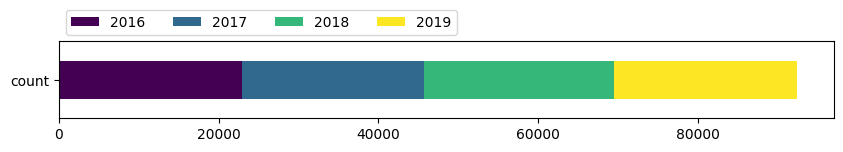

In [6]:
# filter to 2019

df = df.rename(columns = {'year': 'YEAR'})
StackedHorizontalBar(df, 'YEAR')

# df = df[df['YEAR'] == 2019]
# df = df.reset_index(drop = True)

In [7]:
# date of departure = date of arrival + length of stay
# month of arrival = month(date of arrival)
# month of departure = month(date of departure)

df['DATE_OF_ARRIVAL'] = pd.to_datetime(df['a7'])
df['DATE_OF_DEPARTURE'] = df['DATE_OF_ARRIVAL'] + pd.to_timedelta(df['b10'], unit = 'd')
df['MONTH_OF_ARRIVAL'] = df['DATE_OF_ARRIVAL'].dt.month.astype('Int64')
df['MONTH_OF_DEPARTURE'] = df['DATE_OF_DEPARTURE'].dt.month.astype('Int64')
df['LENGTH_OF_STAY'] = df['b10'].astype('Int64')

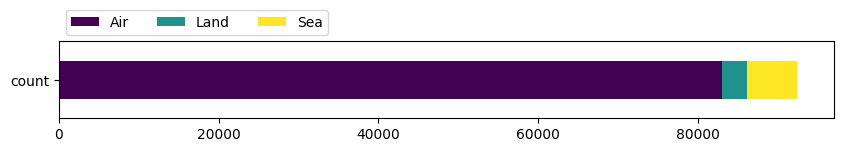

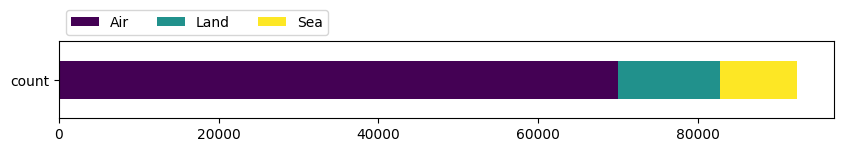

In [8]:
# mode of transport (depature/arrival) = air/land/sea

df['MODE_OF_ARRIVAL'] = df['b2'].astype('Int64').astype(str).map(label_map['b2'])
df['MODE_OF_DEPARTURE'] = df['m1'].astype('Int64').astype(str).map(label_map['m1'])

mode_counts1 = df['MODE_OF_ARRIVAL'].value_counts(dropna = False).reset_index().rename(columns = {'index': 'Value', 0: 'Count'})
mode_counts2 = df['MODE_OF_DEPARTURE'].value_counts(dropna = False).reset_index().rename(columns = {'index': 'Value', 0: 'Count'})

StackedHorizontalBar(df, 'MODE_OF_ARRIVAL')
StackedHorizontalBar(df, 'MODE_OF_DEPARTURE')

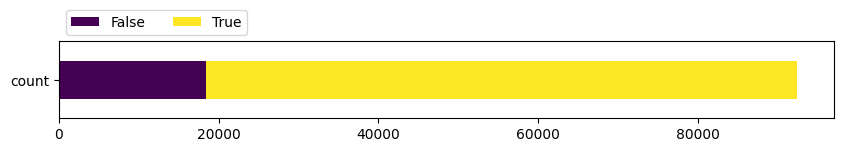

In [9]:
# language of interview
# convert to boolean English and non-English

df = df.rename(columns = {'languageq': 'LANGUAGE_OF_INTERVIEW'})
df['INTERVIEW_IN_ENGLISH'] = (df['LANGUAGE_OF_INTERVIEW'] == 1)
df['INTERVIEW_IN_ENGLISH'] = df['INTERVIEW_IN_ENGLISH'].where(df['LANGUAGE_OF_INTERVIEW'] != -1, pd.NA)

StackedHorizontalBar(df, 'INTERVIEW_IN_ENGLISH')

In [10]:
# type of passenger

# note: this column seems to be already filtered to departing passengers only so can be dropped
df = df.rename(columns = {'a1': 'PASSENGER_TYPE'})

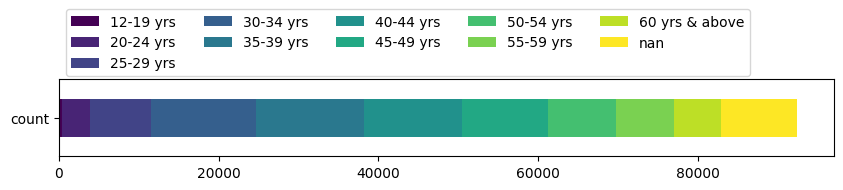

In [11]:
# age band

df['AGE_BAND'] = df['a2.r'].astype('Int64').astype(str).map(label_map['a2.r.10l'])

StackedHorizontalBar(df, 'AGE_BAND')

% MISSING: 0.00%


Text(0.5, 0, 'Count')

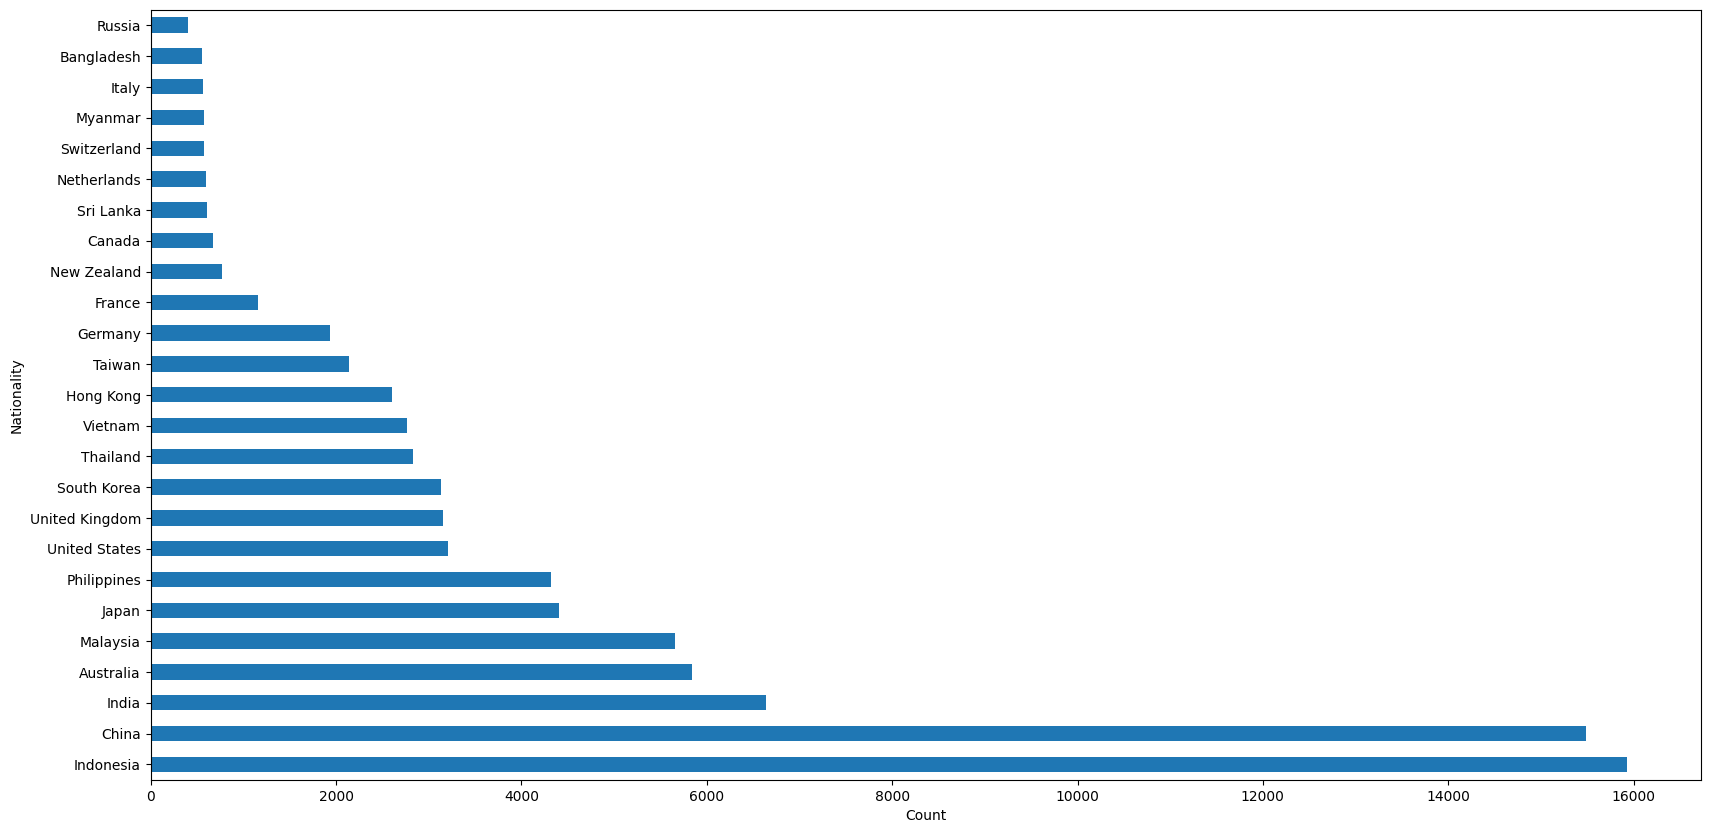

In [12]:
# nationality

df['a4.raw'] = df['a4'].astype('Int64').astype(str).map(label_map['a4'])
df['NATIONALITY'] = df['a4.raw'].map(label_map['NATIONALITY_TO_COUNTRY'])
df['NATIONALITY'] = df['NATIONALITY'].fillna(df['a4.raw'])


print(f"% MISSING: {df['NATIONALITY'].isnull().mean()*100:.2f}%")

ax = df['NATIONALITY'].value_counts()\
                      .nlargest(25)\
                      .plot(kind = 'barh',
                            figsize = (20,10))
ax.set_ylabel("Nationality")
ax.set_xlabel("Count")

% MISSING: 0.00%


Text(0.5, 0, 'Count')

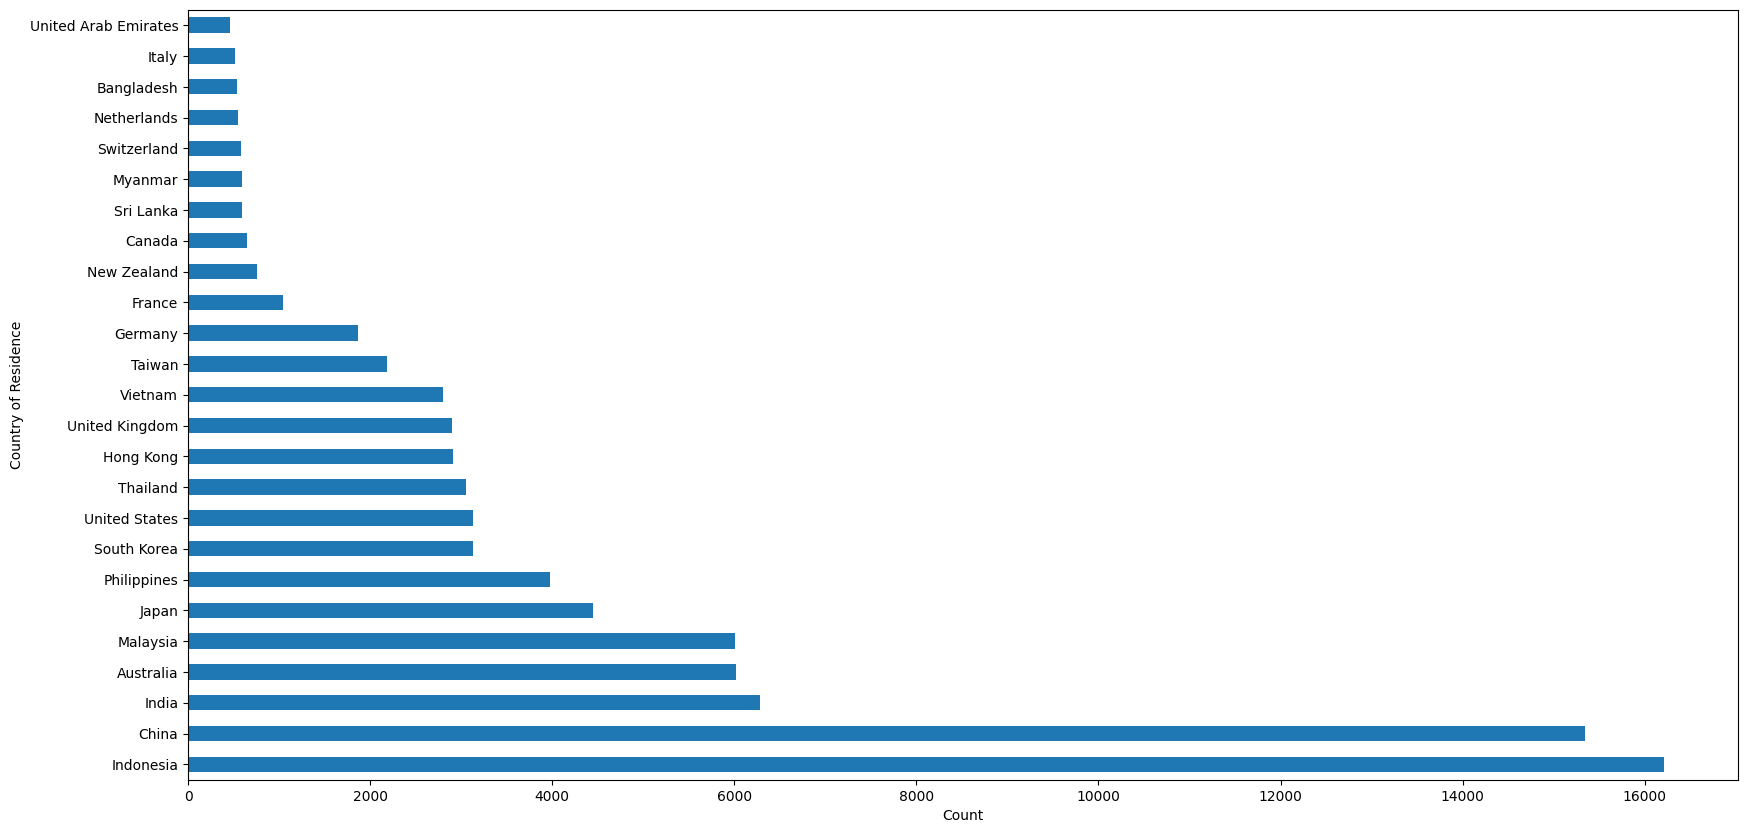

In [13]:
# country of residence

df['COUNTRY_OF_RESIDENCE'] = df['a5'].astype('Int64').astype(str).map(label_map['a5'])
print(f"% MISSING: {df['COUNTRY_OF_RESIDENCE'].isnull().mean()*100:.2f}%")

ax = df['COUNTRY_OF_RESIDENCE'].value_counts()\
                               .nlargest(25)\
                               .plot(kind = 'barh',
                                     figsize = (20,10))
ax.set_ylabel("Country of Residence")
ax.set_xlabel("Count")

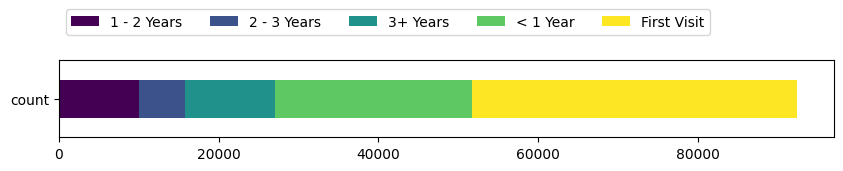

In [14]:
# time since last visit

time_map = {
    0: 'First Visit',
    1: '< 1 Year',
    2: '1 - 2 Years',
    3: '2 - 3 Years',
    4: '3+ Years'
}
df['TIME_SINCE_LAST_VISIT'] = df['b1b'].astype('Int64').fillna(0).map(time_map)

StackedHorizontalBar(df, 'TIME_SINCE_LAST_VISIT')

Text(0.5, 0, 'Count')

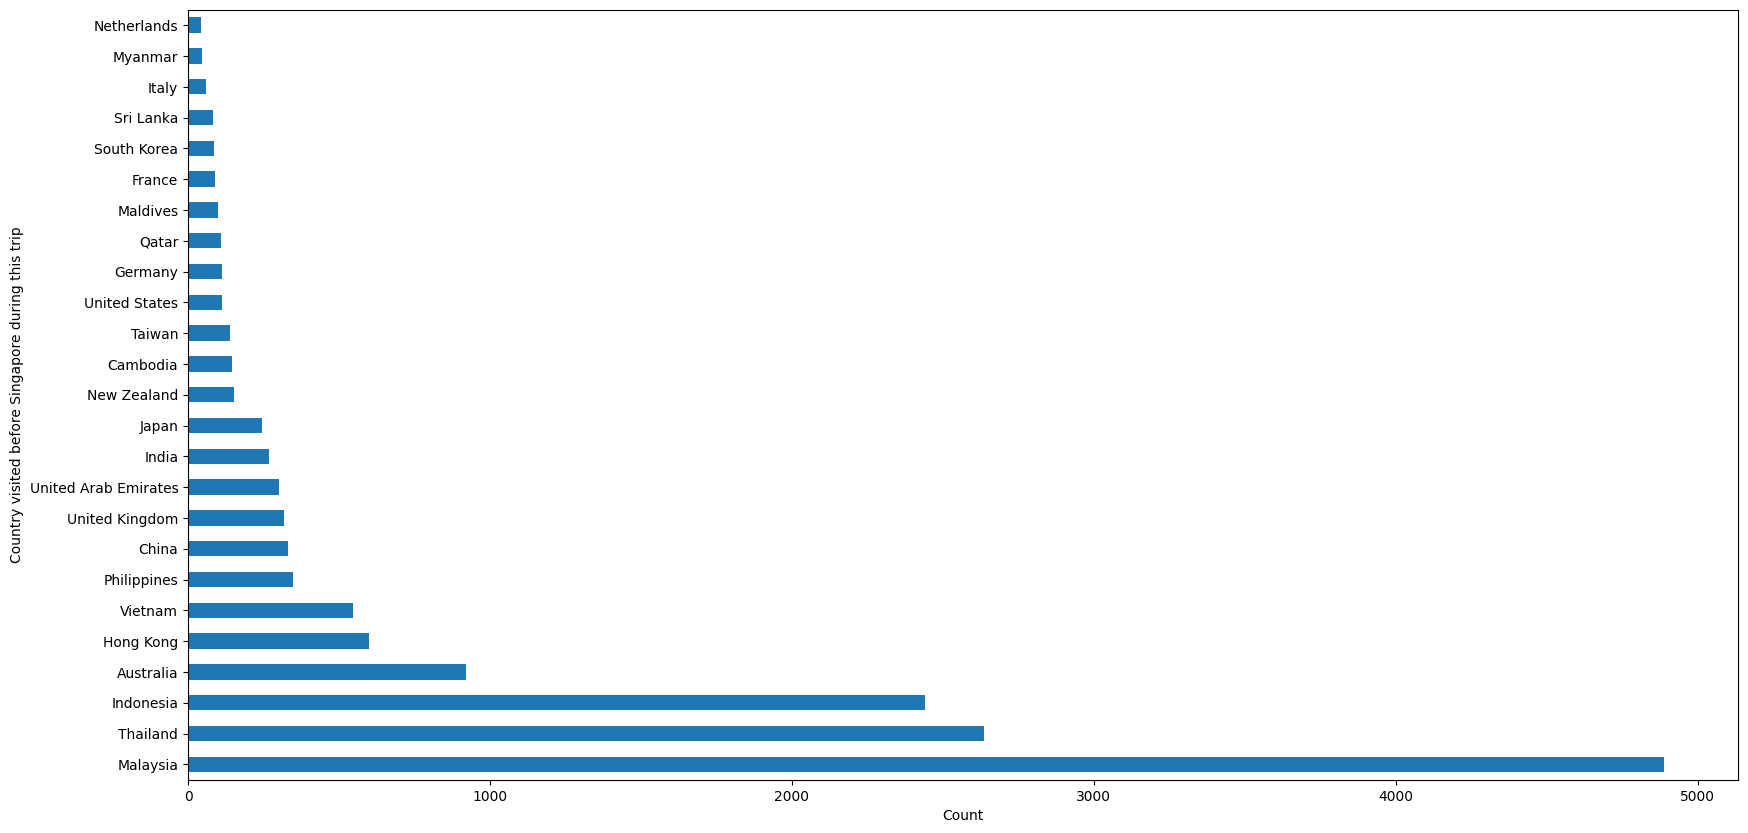

In [15]:
df['Country before SG'] = df['b7a'].astype('Int64').astype(str).map(label_map['b7a'])

ax = df['Country before SG'].value_counts()\
                            .nlargest(25)\
                            .plot(kind = 'barh',
                                  figsize = (20,10))
ax.set_ylabel("Country visited before Singapore during this trip")
ax.set_xlabel("Count")

% MISSING (before imputation): 85.58%
% MISSING (after imputation): 0.00%


Text(0.5, 0, 'Count')

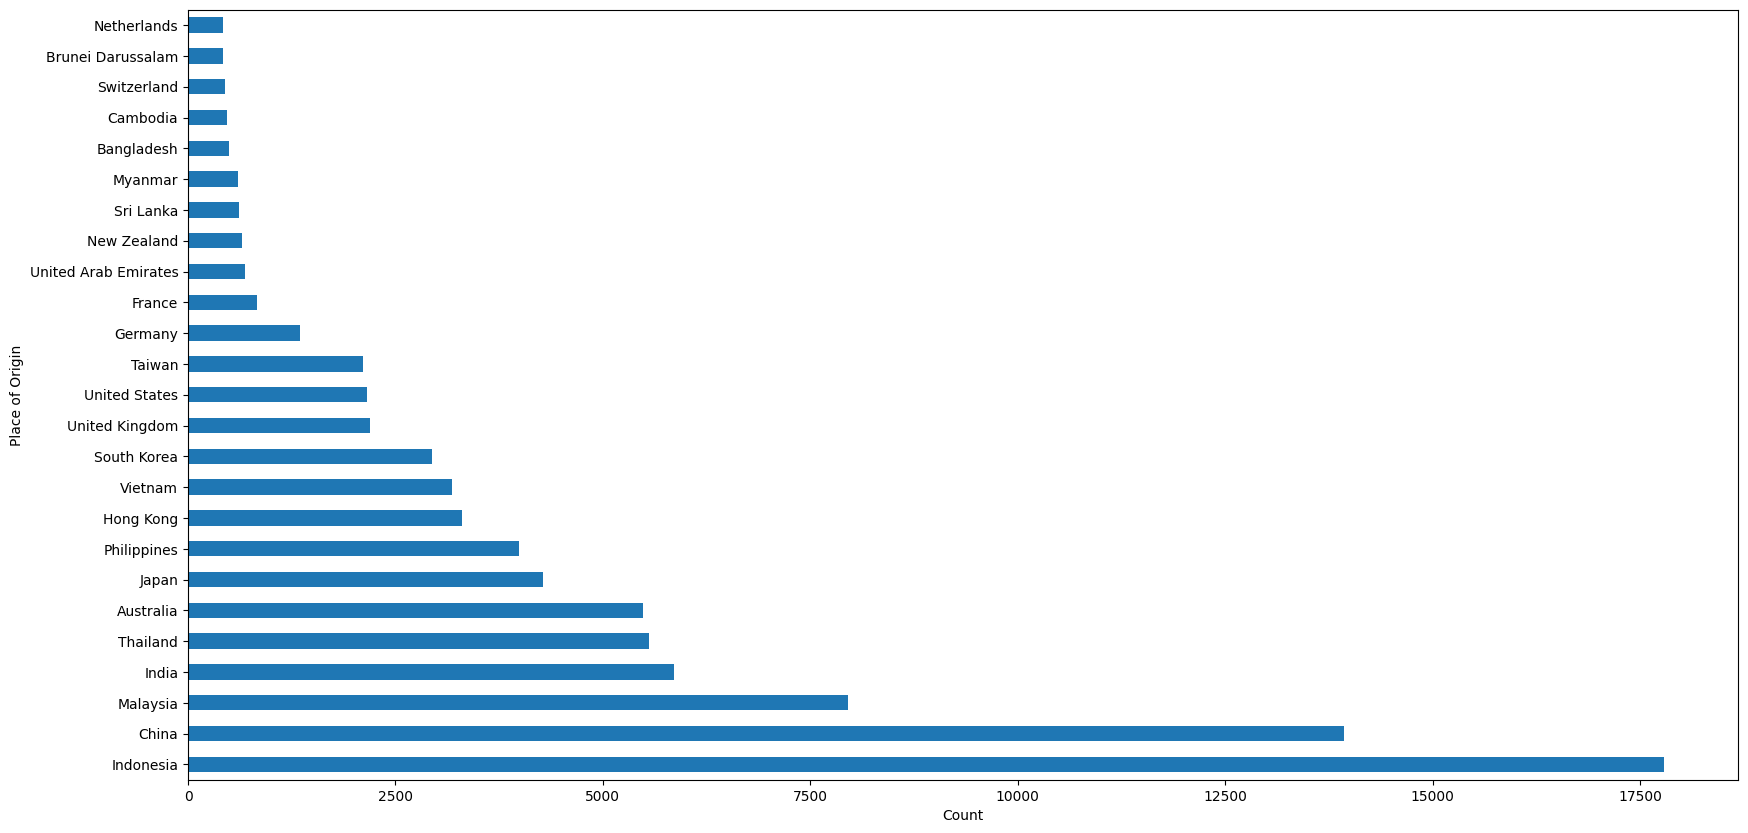

In [16]:
# place of origin =
# - state in Malaysia if mode of arrival == land
# - country before Singapore o/w
# - country of residence if missing
# - nationality if missing

# note: for some reason b4 (State in Malaysia) is unfilled for all individuals
df['State in Malaysia'] = df['b4'].astype('Int64').astype(str).map(label_map['b4']).apply(lambda x: "Malaysia - " + str(x))
df['State in Malaysia'] = df['State in Malaysia'].replace("Malaysia - Others:", "Malaysia")
df['State in Malaysia'] = df['State in Malaysia'].replace("Malaysia - nan", None)

df['PLACE_OF_ORIGIN'] = np.where(df['MODE_OF_ARRIVAL'] == 'Land', df['State in Malaysia'], df['b7a'].astype('Int64').astype(str).map(label_map['b7a']))
print(f"% MISSING (before imputation): {df['PLACE_OF_ORIGIN'].isnull().mean()*100:.2f}%")
df['PLACE_OF_ORIGIN'] = df['PLACE_OF_ORIGIN'].fillna(df['COUNTRY_OF_RESIDENCE']).fillna(df['NATIONALITY'])

print(f"% MISSING (after imputation): {df['PLACE_OF_ORIGIN'].isnull().mean()*100:.2f}%")

ax = df['PLACE_OF_ORIGIN'].value_counts()\
                          .nlargest(25)\
                          .plot(kind = 'barh',
                                figsize = (20,10))
ax.set_ylabel("Place of Origin")
ax.set_xlabel("Count")

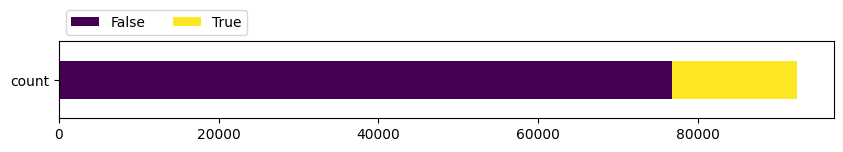

In [17]:
df['MULTICOUNTRY_TRIP'] = np.where(df['Country before SG'].isna(), False, True)

StackedHorizontalBar(df, 'MULTICOUNTRY_TRIP')

Text(0.5, 0, 'Count')

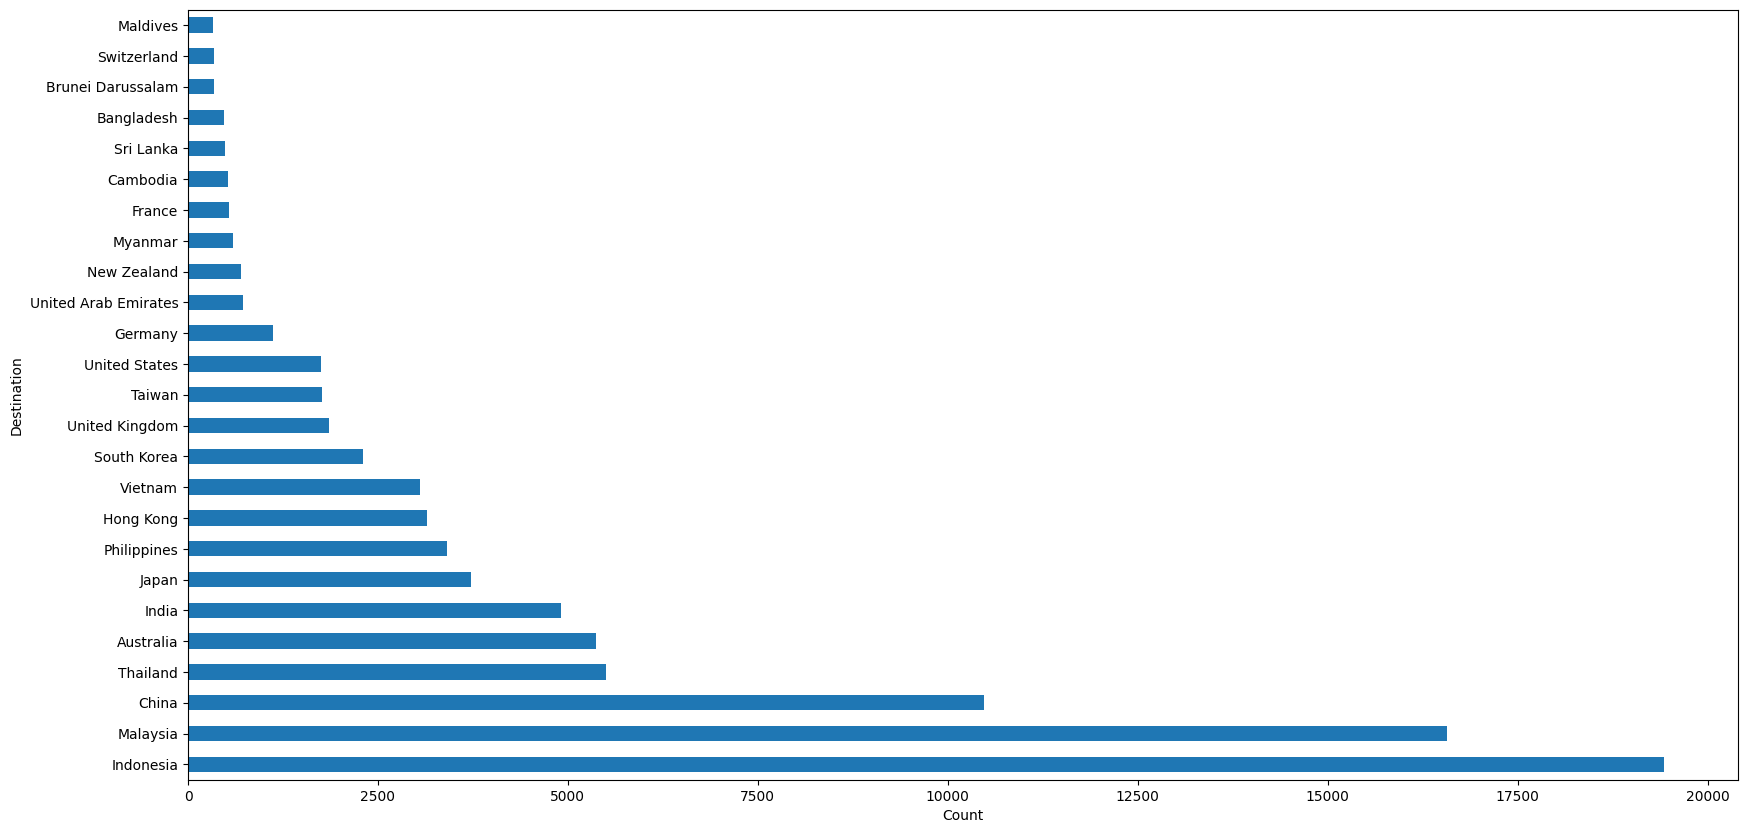

In [18]:
# destination = 
# - country after Singapore
# - country of residence if missing
# - nationality if missing

df['DESTINATION'] = df['b9a'].astype('Int64').astype(str).map(label_map['b9a'])\
                             .fillna(df['COUNTRY_OF_RESIDENCE']).fillna(df['NATIONALITY'])

ax = df['DESTINATION'].value_counts()\
                      .nlargest(25)\
                      .plot(kind = 'barh',
                            figsize = (20,10))
ax.set_ylabel("Destination")
ax.set_xlabel("Count")

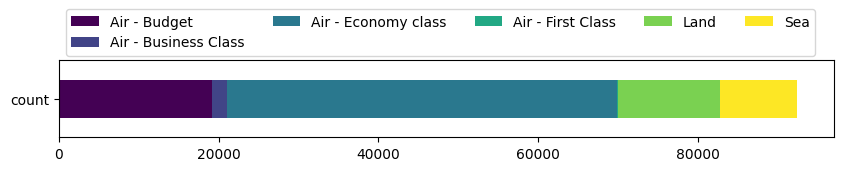

In [19]:
# mode of transport = passenger class x mode of departure

df['Class (Air)'] = df['b3b'].astype('Int64').astype(str).map(label_map['b3b']).apply(lambda x: "Air - " + str(x))
df['Class (Air)'] = df['Class (Air)'].replace("Air - nan", "Air - Economy class")

df['Class (Land)'] = df['b5'].astype('Int64').astype(str).map(label_map['b5']).apply(lambda x: "Land - " + str(x))
df['Class (Land)'] = df['Class (Land)'].replace("Land - nan", "Land")

df['MODE_OF_TRANSPORT'] = np.where(df['MODE_OF_DEPARTURE'] == 'Air', df['Class (Air)'],
                                   np.where(df['MODE_OF_DEPARTURE'] == 'Land', df['Class (Land)'], df['MODE_OF_DEPARTURE']))

StackedHorizontalBar(df, 'MODE_OF_TRANSPORT')

In [20]:
# nights spent before/after Singapore

df['NIGHTS_BEFORE_SG'] = df['b7c'].astype('Int64').fillna(0)
df['NIGHTS_AFTER_SG'] = df['b9c'].astype('Int64').fillna(0)

# impute nights spent before Singapore with
# - 0 if place of origin == country of residence or nationality
# - mode when grouped by same place of origin, if data is available
# - mode of all filled values o/w

conditions = (df['PLACE_OF_ORIGIN'] == df['COUNTRY_OF_RESIDENCE']) | (df['PLACE_OF_ORIGIN'] == df['NATIONALITY'])
df.loc[conditions, 'NIGHTS_BEFORE_SG'] = df.loc[conditions, 'b7c'].fillna(0).astype('Int64')
modes = df.groupby('PLACE_OF_ORIGIN')['NIGHTS_BEFORE_SG'].apply(lambda x: x.mode())
df['NIGHTS_BEFORE_SG'] = df.apply(
    lambda row: modes[row['PLACE_OF_ORIGIN']] if pd.isna(row['NIGHTS_BEFORE_SG']) else row['NIGHTS_BEFORE_SG'],
    axis = 1
)
overall_mode = df['NIGHTS_BEFORE_SG'].mode().iloc[0]
df['NIGHTS_BEFORE_SG'] = df['NIGHTS_BEFORE_SG'].fillna(overall_mode)

# impute nights spent after Singapore with
# - 0 if destination == country of residence or nationality
# - mode when grouped by same destination, if data is available
# - mode of all filled values o/w

conditions = (df['DESTINATION'] == df['COUNTRY_OF_RESIDENCE']) | (df['PLACE_OF_ORIGIN'] == df['NATIONALITY'])
df.loc[conditions, 'NIGHTS_AFTER_SG'] = df.loc[conditions, 'b9c'].fillna(0).astype('Int64')
modes = df.groupby('DESTINATION')['NIGHTS_AFTER_SG'].apply(lambda x: x.mode())
df['NIGHTS_AFTER_SG'] = df.apply(
    lambda row: modes[row['DESTINATION']] if pd.isna(row['NIGHTS_AFTER_SG']) else row['NIGHTS_AFTER_SG'],
    axis = 1
)
overall_mode = df['NIGHTS_AFTER_SG'].mode().iloc[0]
df['NIGHTS_AFTER_SG'] = df['NIGHTS_AFTER_SG'].fillna(overall_mode)

Text(0.5, 0, 'Count')

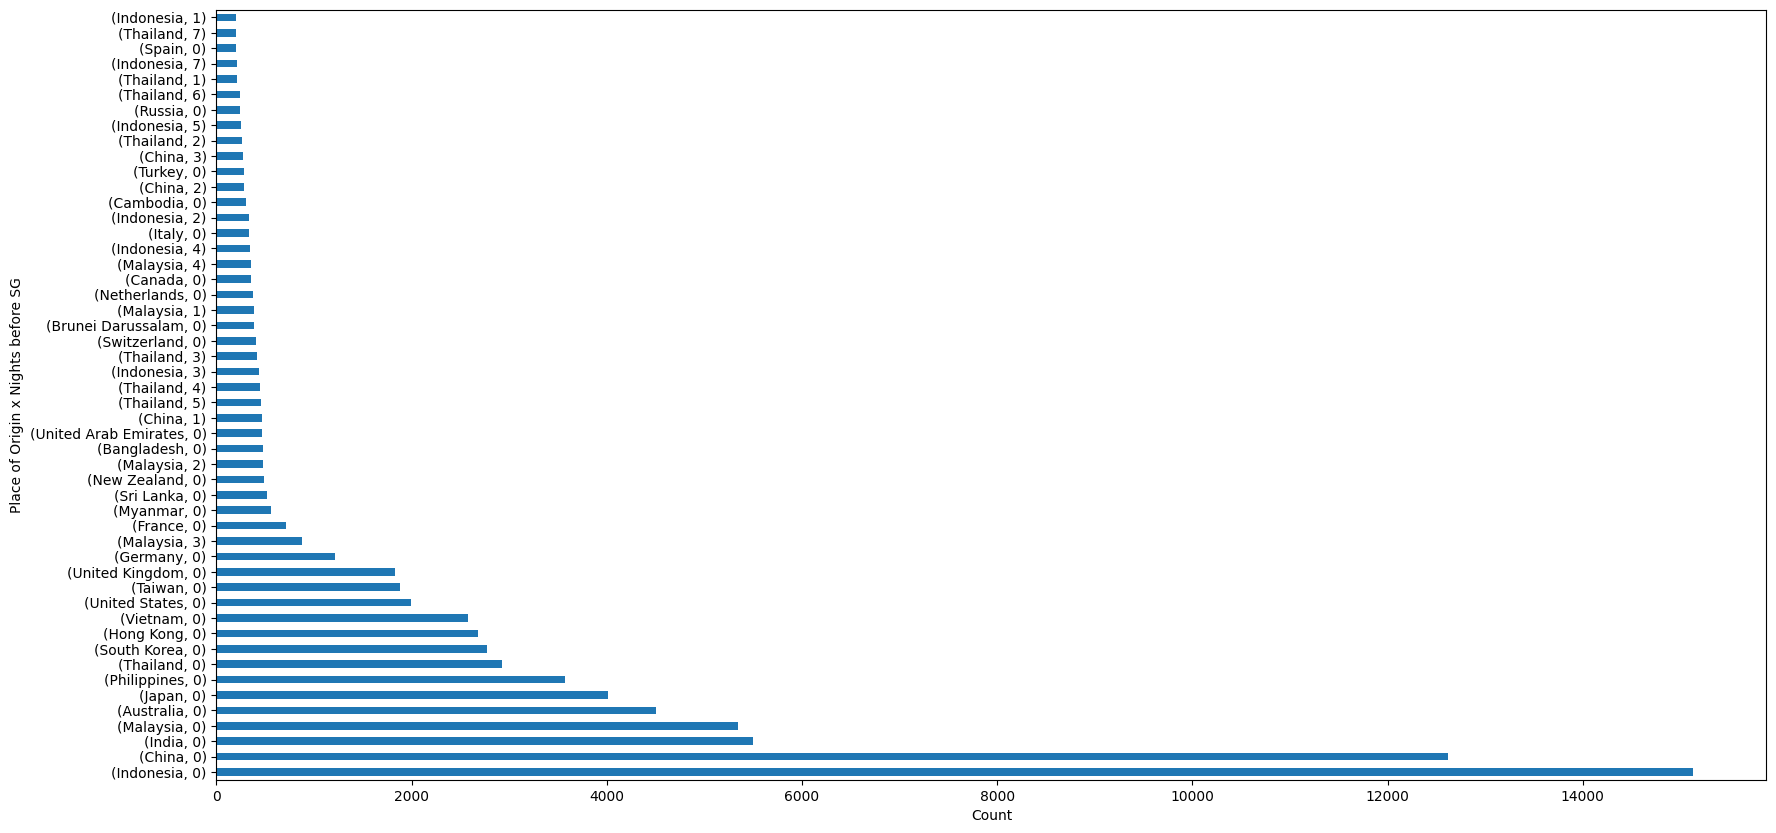

In [21]:
ax = df[['PLACE_OF_ORIGIN','NIGHTS_BEFORE_SG']].groupby('PLACE_OF_ORIGIN')\
                                               .value_counts()\
                                               .nlargest(50)\
                                               .plot(kind = 'barh',
                                                     figsize = (20,10))
ax.set_ylabel("Place of Origin x Nights before SG")
ax.set_xlabel("Count")

Text(0.5, 0, 'Count')

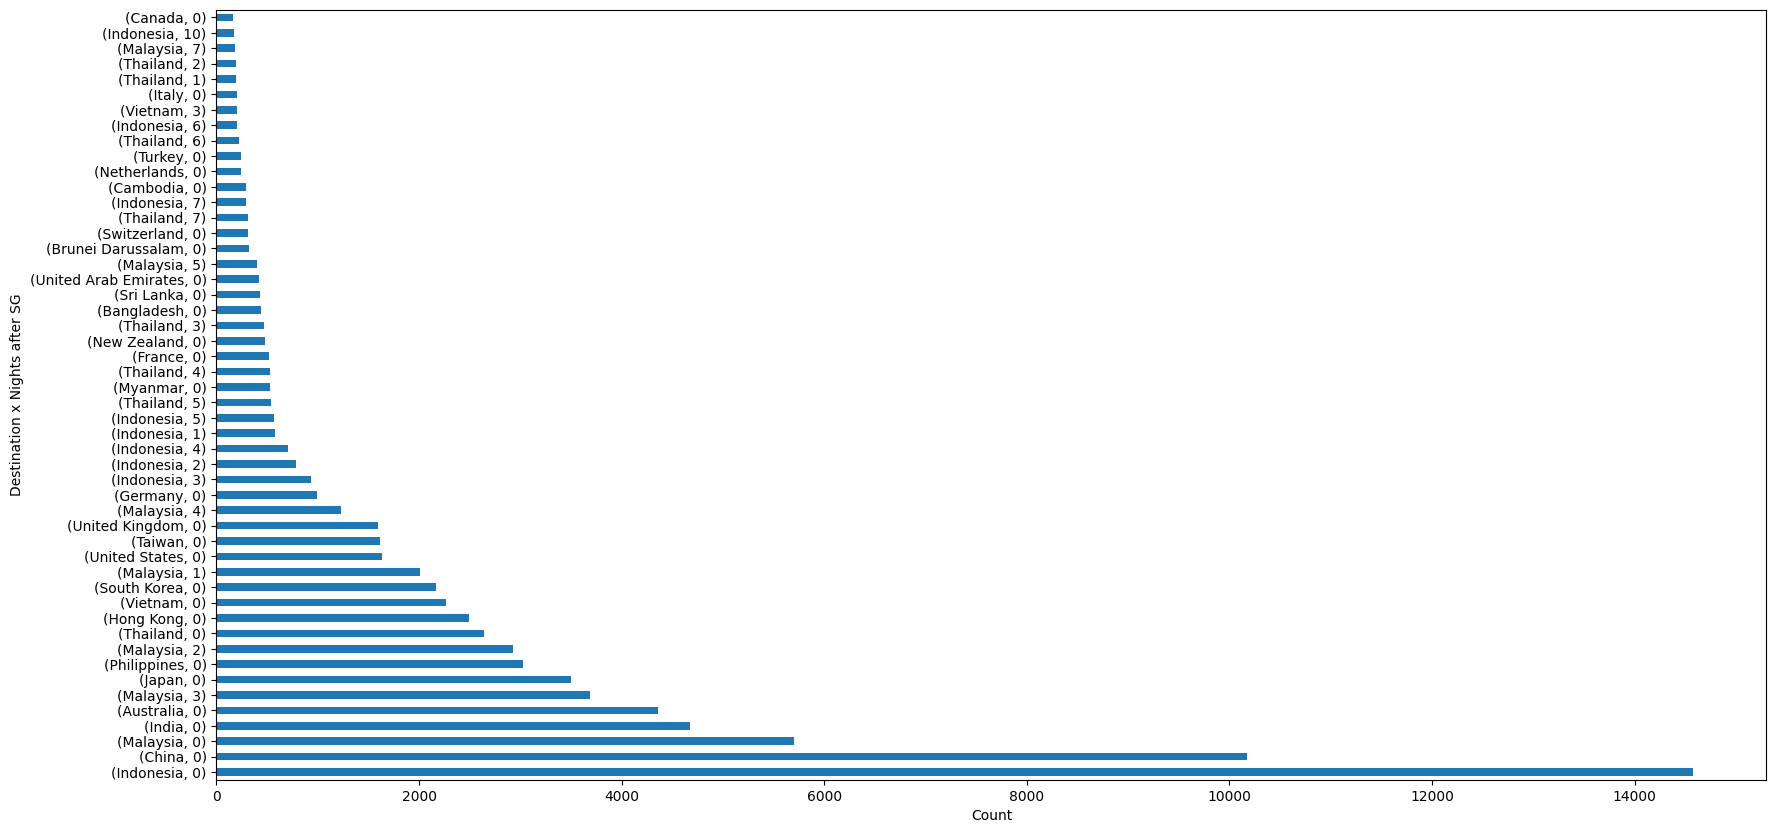

In [22]:
ax = df[['DESTINATION','NIGHTS_AFTER_SG']].groupby('DESTINATION')\
                                          .value_counts()\
                                          .nlargest(50)\
                                          .plot(kind = 'barh',
                                                figsize = (20,10))
ax.set_ylabel("Destination x Nights after SG")
ax.set_xlabel("Count")

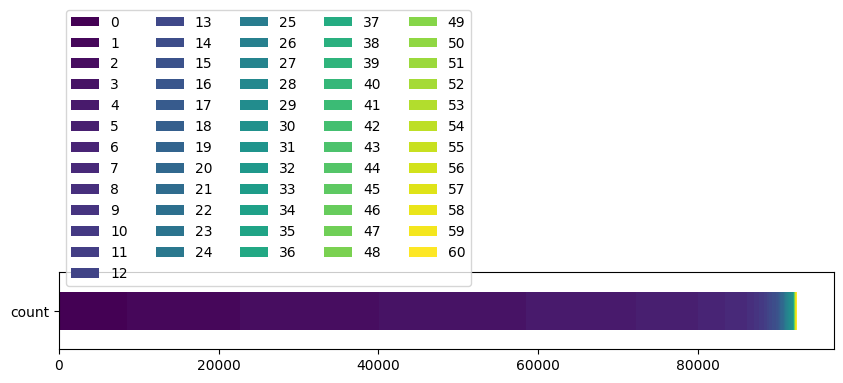

In [23]:
# length of stay

df['LENGTH_OF_STAY'] = df['b10'].astype('Int64')

StackedHorizontalBar(df, 'LENGTH_OF_STAY')

In [24]:
# travel companion(s)

# includes spouse
df['TRAVEL_COMPANION=SPOUSE'] = df['b12_2'].astype('Int64').fillna(0)

# includes partner
df['TRAVEL_COMPANION=PARTNER'] = df['b12_3'].astype('Int64').fillna(0)

# number of parents
df['N_PARENTS'] = df['b12number_2'].astype('Int64').fillna(0)

# number of grandparents
df['N_GRANDPARENTS'] = df['b12number_3'].astype('Int64').fillna(0)

# number of siblings
df['N_SIBLINGS'] = df['b12number_4'].astype('Int64').fillna(0)

# number of other relatives
df['N_OTHER_RELATIVES'] = df['b12number_5'].astype('Int64').fillna(0)

# number of friends
df['N_FRIENDS'] = df['b12number_6'].astype('Int64').fillna(0)

# number of other companions
df['N_OTHERS'] = df[['b12number_7', 'b12number_8', 'b12number_9']].sum(axis=1, skipna=True).astype('Int64').fillna(0)

# number of children
df['N_CHILDREN'] = df['b12number_2'].astype('Int64').fillna(0)

# boolean for child(ren) in 0-12, 13-19 age band
df['BOOL_CHILD_0to12Years'] = np.where(df['b12b_1'].astype('Int64').fillna(0) > 0, True, False)
df['BOOL_CHILD_13to19Years'] = np.where(df['b12b_2'].astype('Int64').fillna(0) > 0, True, False)

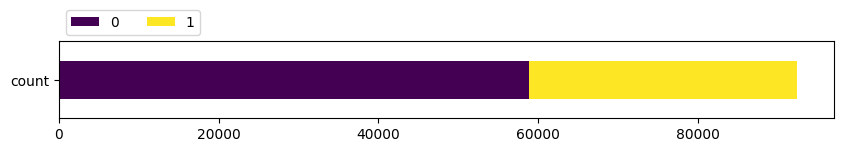

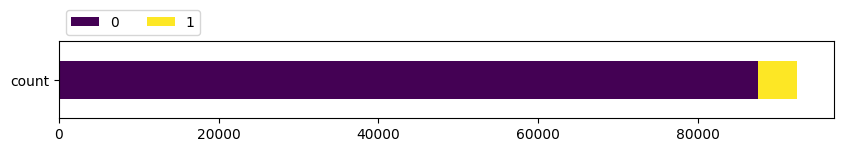

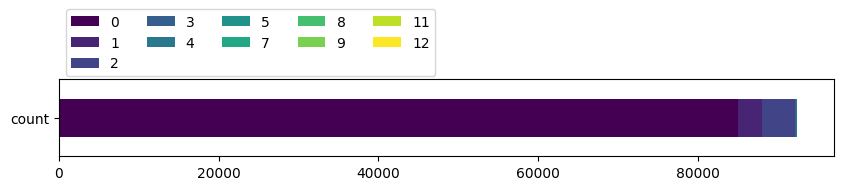

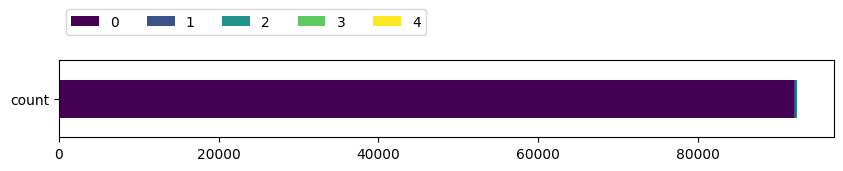

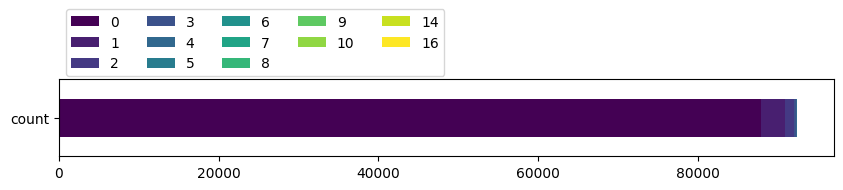

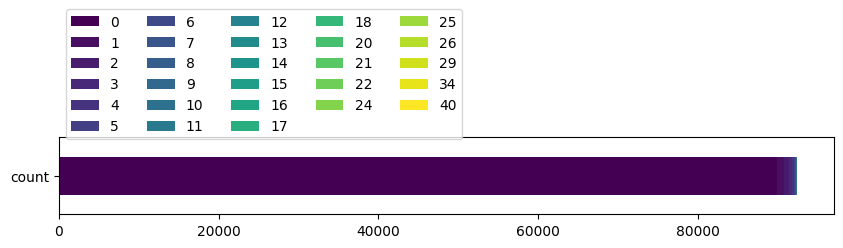

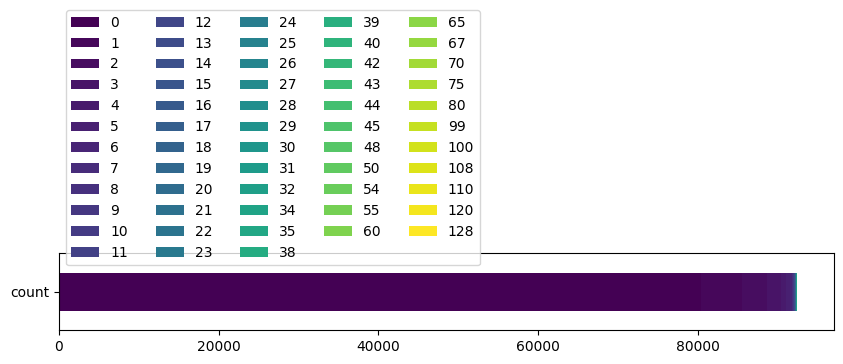

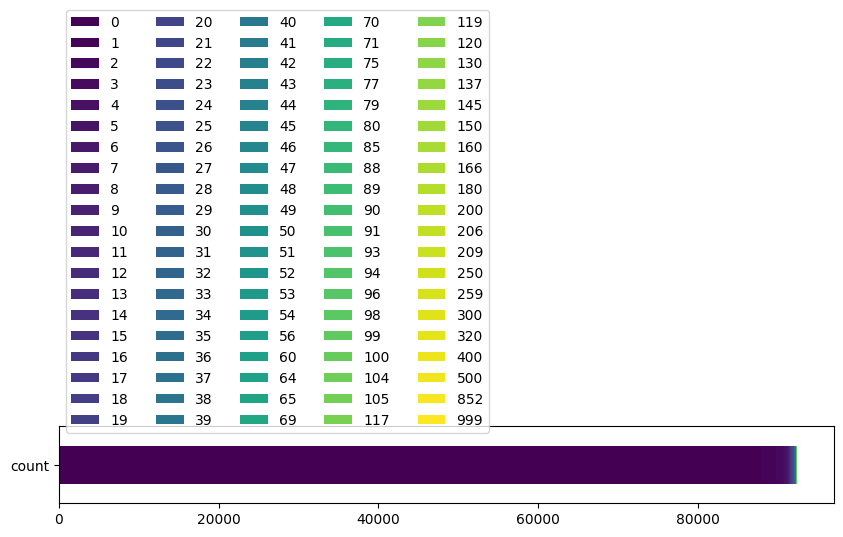

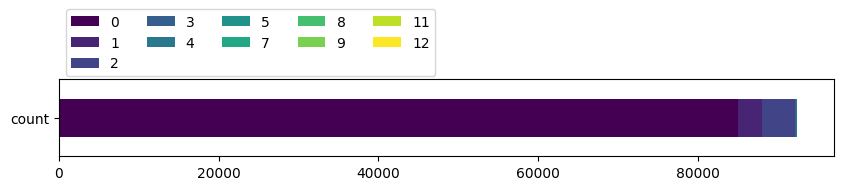

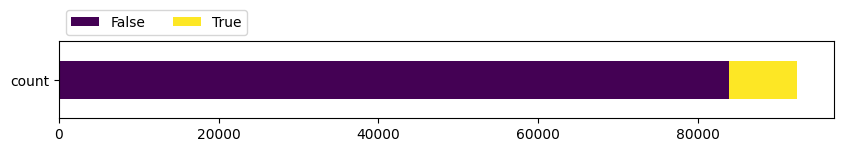

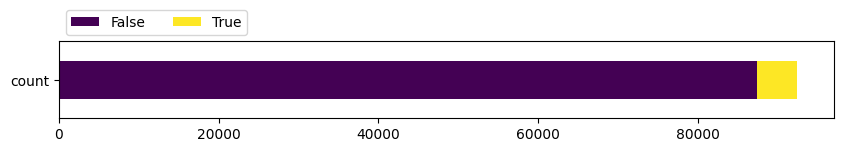

In [25]:
StackedHorizontalBar(df, 'TRAVEL_COMPANION=SPOUSE')
StackedHorizontalBar(df, 'TRAVEL_COMPANION=PARTNER')
StackedHorizontalBar(df, 'N_PARENTS')
StackedHorizontalBar(df, 'N_GRANDPARENTS')
StackedHorizontalBar(df, 'N_SIBLINGS')
StackedHorizontalBar(df, 'N_OTHER_RELATIVES')
StackedHorizontalBar(df, 'N_FRIENDS')
StackedHorizontalBar(df, 'N_OTHERS')
StackedHorizontalBar(df, 'N_CHILDREN')
StackedHorizontalBar(df, 'BOOL_CHILD_0to12Years')
StackedHorizontalBar(df, 'BOOL_CHILD_13to19Years')

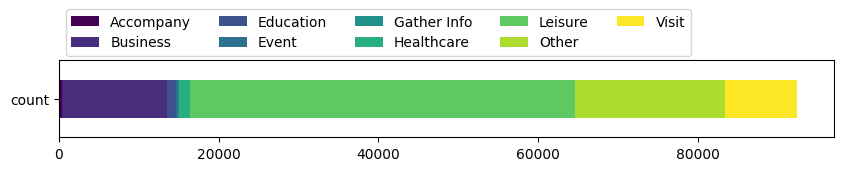

In [26]:
# main purpose of visit

pov_map = {
    'b13a_111': 'Event',
    'b13a_112': 'Leisure',
    'b13a_113': 'Accompany',
    'b13a_114': 'Visit',
    'b13a_115': 'Gather Info',
    'b13a_116': 'Business',
    'b13a_117': 'Healthcare',
    'b13a_118': 'Education',
    'b13a_119': 'Other'
}

def MainPOV(row):
    columns = list(pov_map.keys())
    active_columns = [col for col in columns if row[col] == 1]
    if len(active_columns) == 1:
        return pov_map[active_columns[0]]
    else:
        return 'Other'
    
df['MAIN_POV'] = df.apply(MainPOV, axis=1)

StackedHorizontalBar(df, 'MAIN_POV')

/tmp/ipykernel_1596/3536814069.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[list(subpov_map.values())] = df[list(subpov_map.values())].applymap(lambda x: False if pd.isna(x) or x == 0 else True)


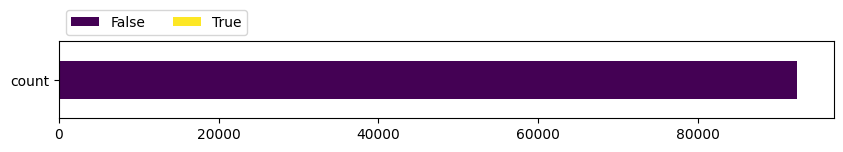

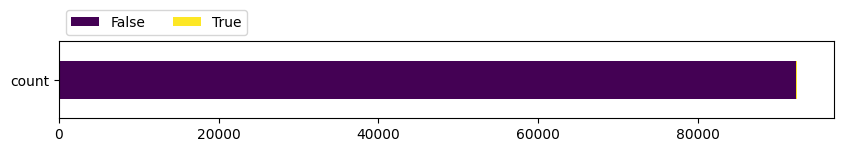

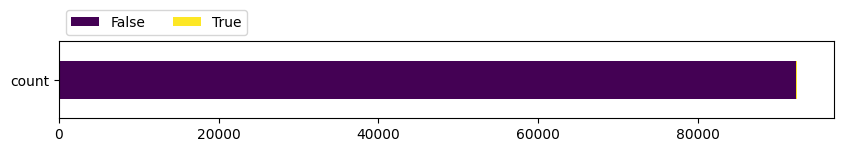

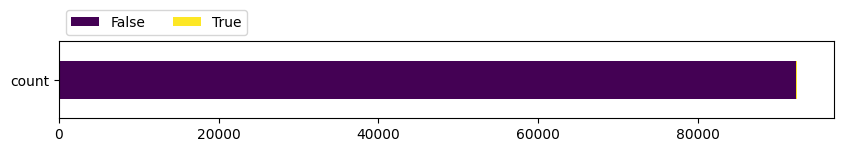

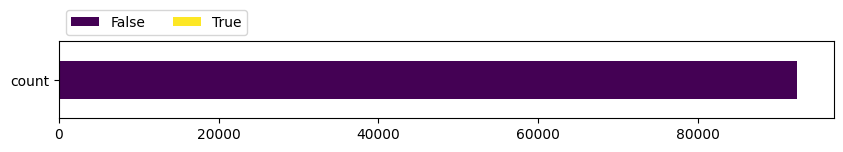

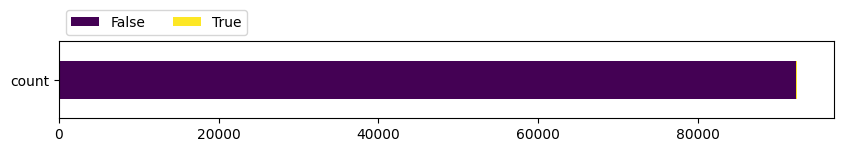

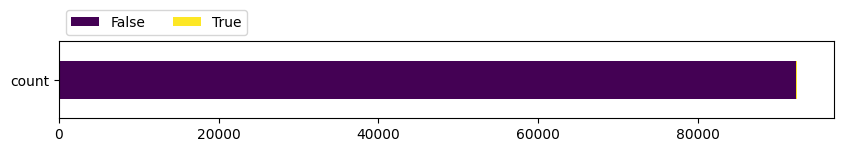

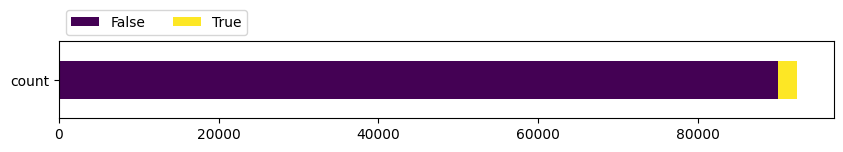

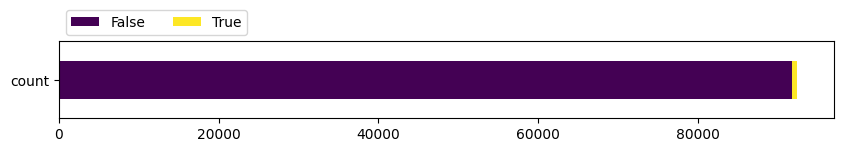

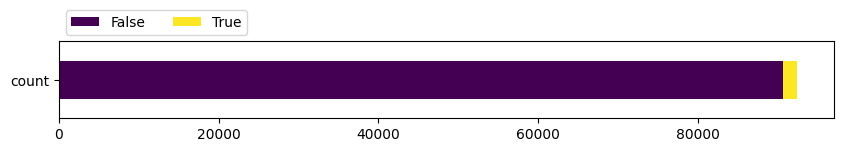

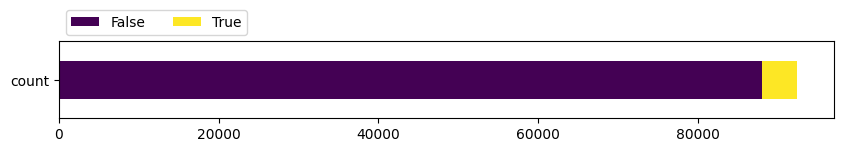

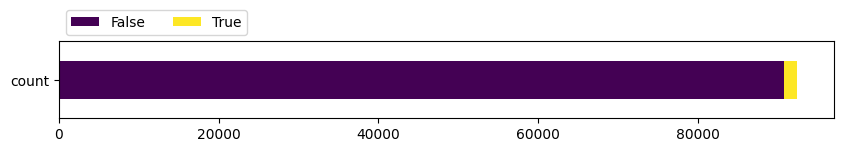

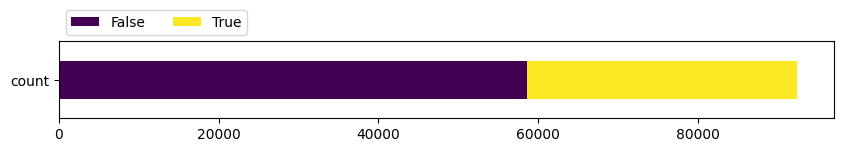

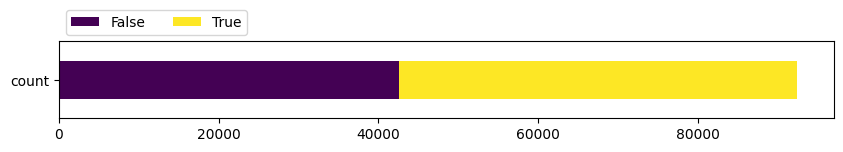

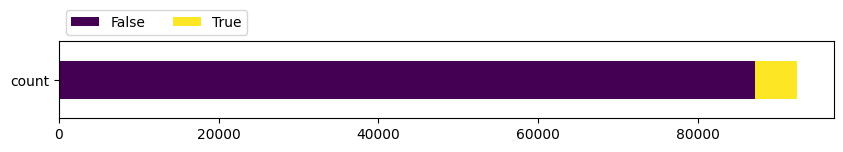

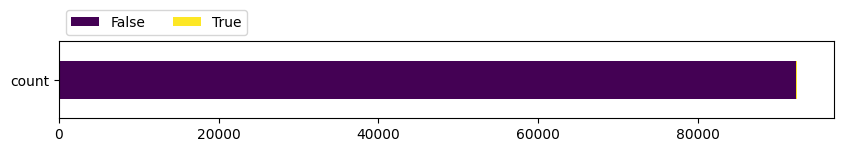

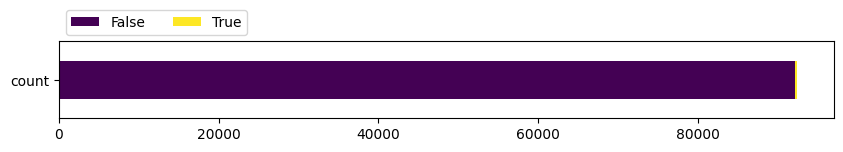

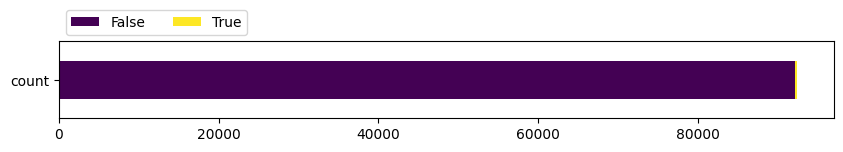

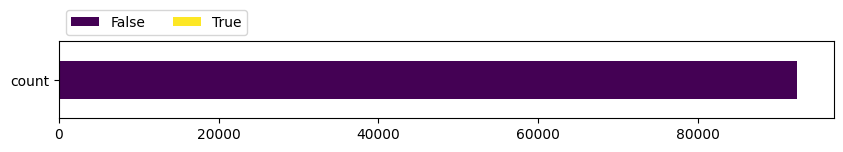

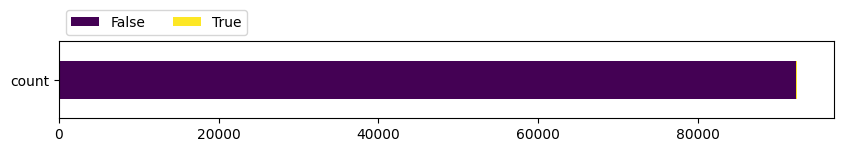

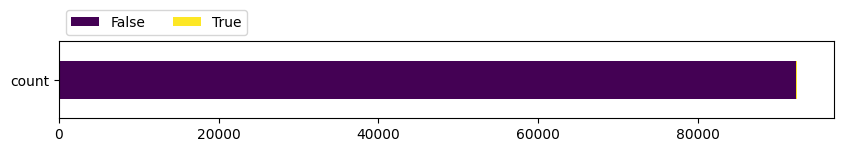

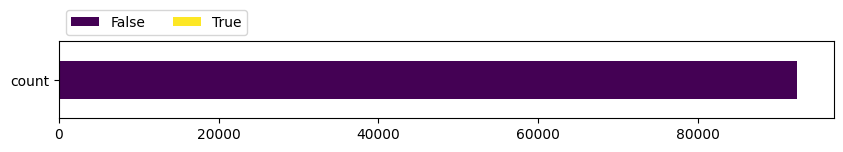

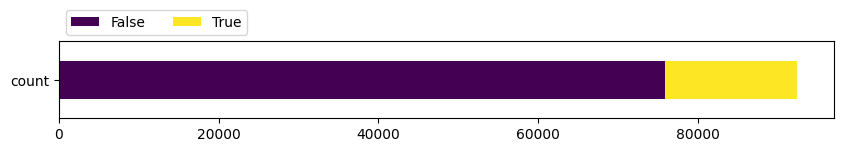

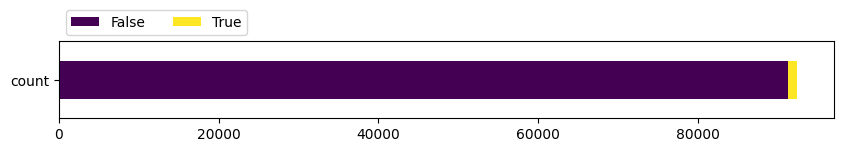

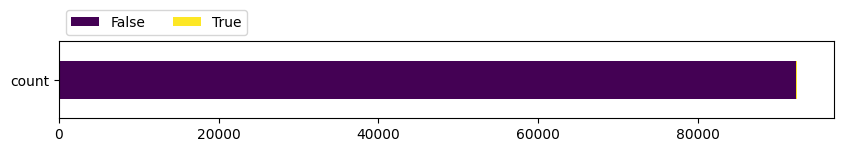

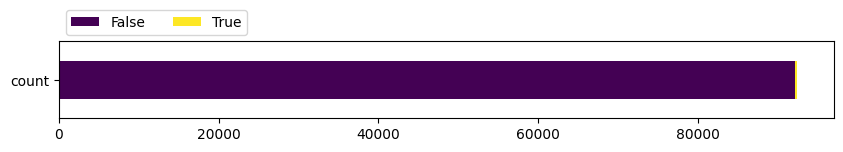

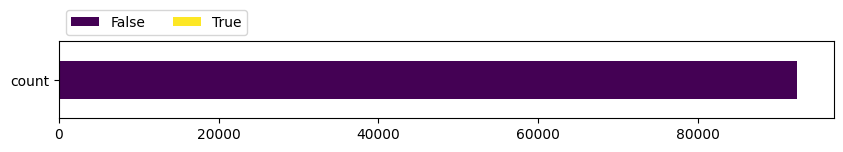

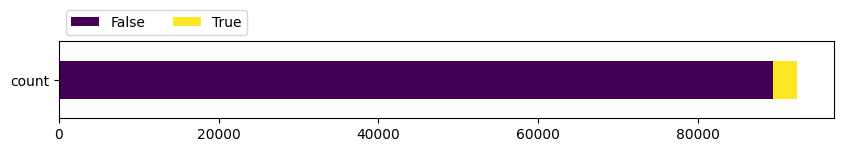

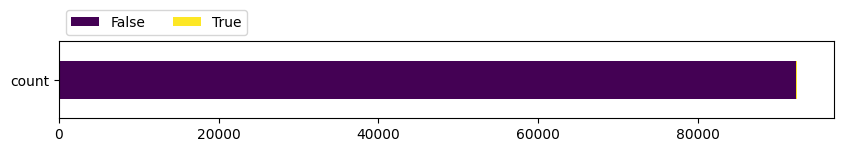

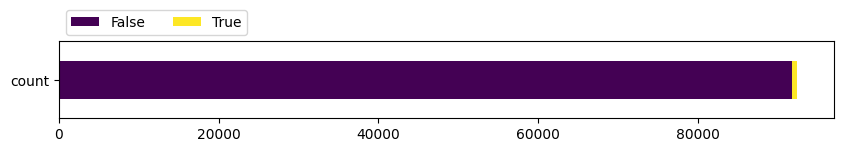

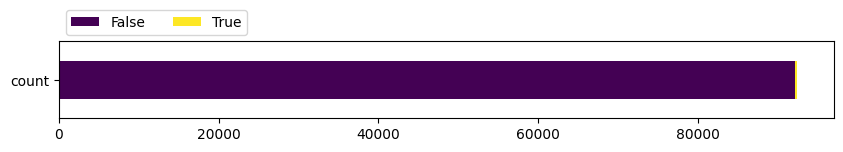

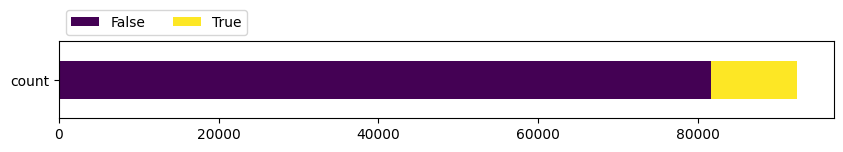

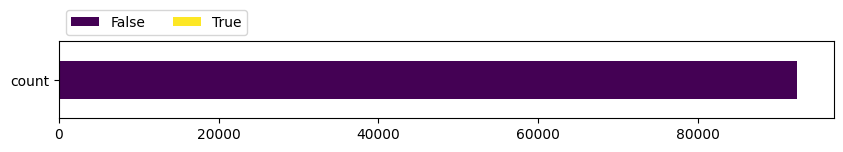

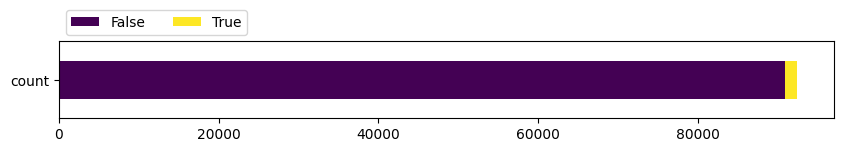

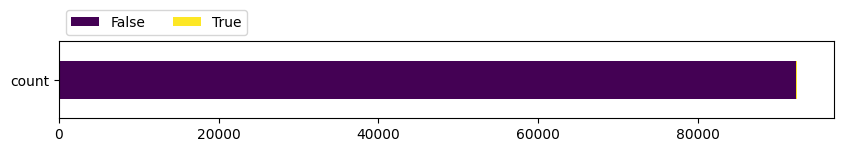

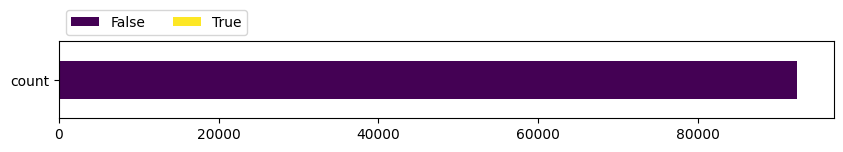

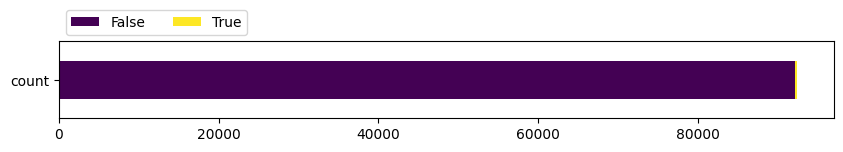

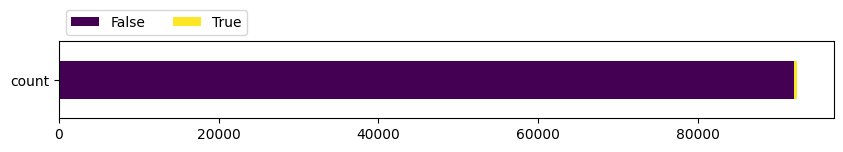

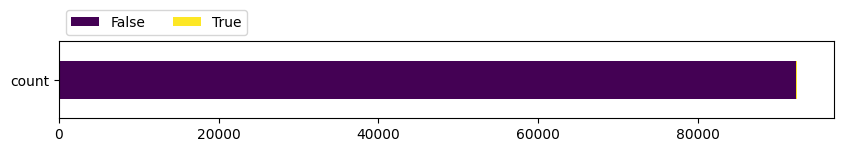

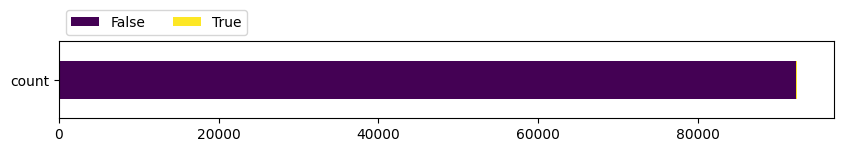

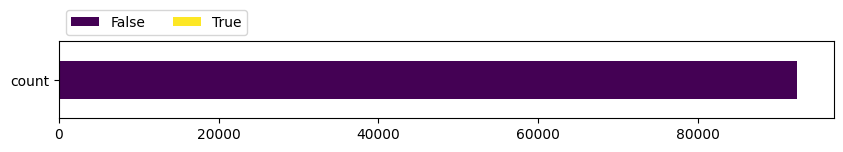

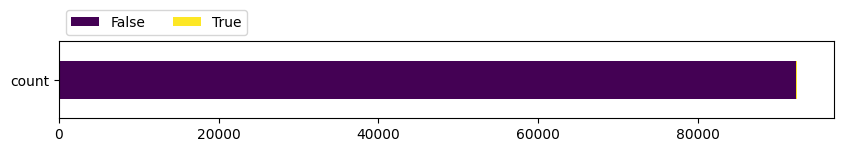

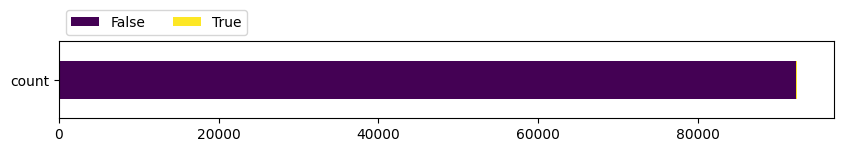

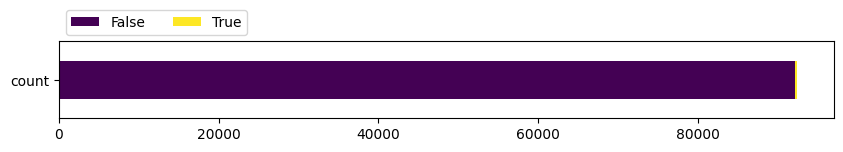

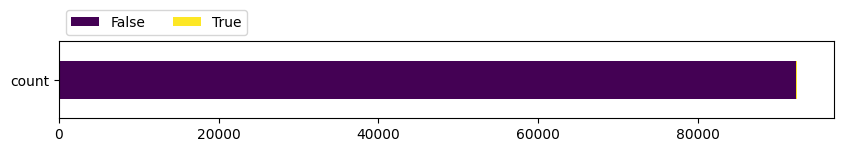

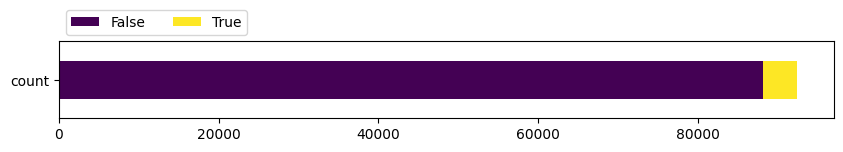

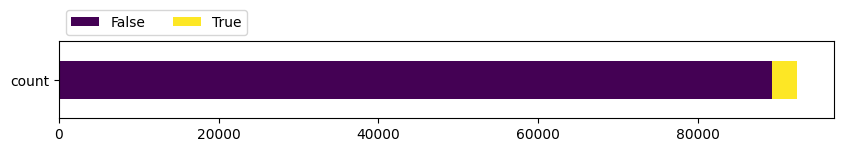

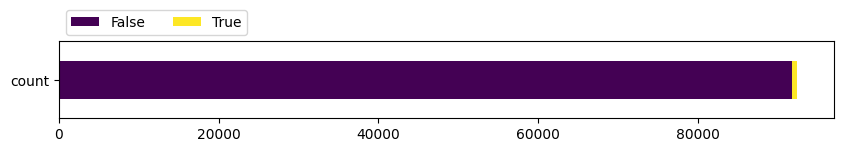

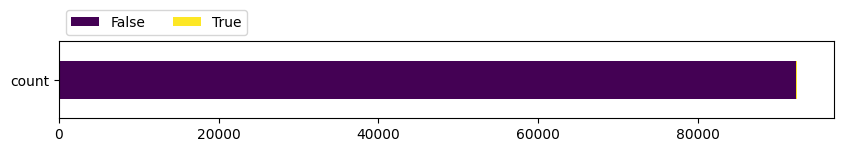

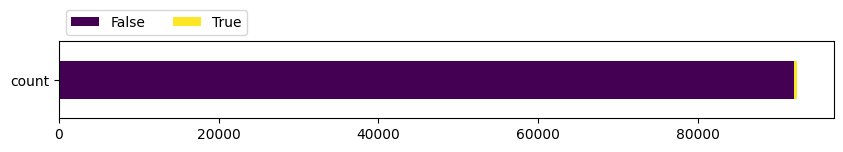

In [27]:
# map purpose of visit subcategory

subpov_map = {
    'b13b_1': 'POV = (Event) Family Entertainment',
    'b13b_2': 'POV = (Event) Performing Arts',
    'b13b_3': 'POV = (Event) Sporting',
    'b13b_4': 'POV = (Event) Music-related',
    'b13b_5': 'POV = (Event) Cultural Festival',
    'b13b_6': 'POV = (Event) Party',
    'b13b_7': 'POV = (Event) Other',
    'b13b_8': 'POV = (Leisure) Food',
    'b13b_9': 'POV = (Leisure) Nightlife',
    'b13b_10': 'POV = (Leisure) Shopping',
    'b13b_11': 'POV = (Leisure) Experience Cultures',
    'b13b_12': 'POV = (Leisure) Cruise',
    'b13b_13': 'POV = (Leisure) Sightseeing',
    'b13b_14': 'POV = (Leisure) Rest & Relax',
    'b13b_15': 'POV = (Leisure) Integrated Resorts',
    'b13b_771': 'POV = (Leisure) Other',
    'b13b_21': 'POV = (Accompany) Business Visitor',
    'b13b_22': 'POV = (Accompany) Outpatient Consultation / Treatment',
    'b13b_23': 'POV = (Accompany) Day Surgery',
    'b13b_24': 'POV = (Accompany) Inpatient Consultation / Treatment',
    'b13b_25': 'POV = (Accompany) International Student',
    'b13b_772': 'POV = (Accompany) Other',
    'b13b_31': 'POV = (Visit) Locals',
    'b13b_32': 'POV = (Visit) International Student',
    'b13b_33': 'POV = (Gather Info) Healthcare',
    'b13b_34': 'POV = (Gather Info) Education',
    'b13b_773': 'POV = (Gather Info) Other',
    'b13b_41': 'POV = (Business) Meeting',
    'b13b_42': 'POV = (Business) Sponsored Holiday',
    'b13b_43': 'POV = (Business) Convention / Conference',
    'b13b_44': 'POV = (Business) Exhibition / Trade Show',
    'b13b_45': 'POV = (Business) General',
    'b13b_774': 'POV = (Business) Other',
    'b13b_51': 'POV = (Healthcare) Outpatient Consultation / Treatment',
#    'bB13b_52': 'POV = (Healthcare) Day Surgery',
    'b13b_53': 'POV = (Healthcare) Inpatient Consultation / Treatment',
    'b13b_775': 'POV = (Healthcare) Other',
    'b13b_61': 'POV = (Education) Company Training',
    'b13b_62': 'POV = (Education) Executive Training',
    'b13b_63': 'POV = (Education) Study Mission',
    'b13b_64': 'POV = (Education) Skills Development',
    'b13b_65': 'POV = (Education) Personal Enrichment',
    'b13b_66': 'POV = (Education) School Trip',
    'b13b_67': 'POV = (Education) Student Event',
    'b13b_68': 'POV = (Education) Student Enrichment',
    'b13b_776': 'POV = (Education) Other',
    'b13b_120': 'POV = (Other) Singapore as a Non-overnight Layover',
    'b13b_121': 'POV = (Other) Singapore as an Overnight Layover',
    'b13b_122': 'POV = (Other) Job Opportunities',
    'b13b_124': 'POV = (Other) Visa / Permit-related',
    'b13b_996': 'POV = (Other) Other'
}
df.rename(columns = subpov_map, inplace = True)
df[list(subpov_map.values())] = df[list(subpov_map.values())].applymap(lambda x: False if pd.isna(x) or x == 0 else True)

for col in list(subpov_map.values()):
    StackedHorizontalBar(df, col)

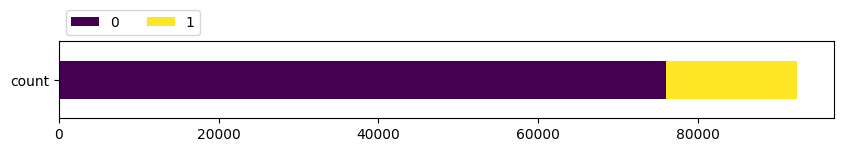

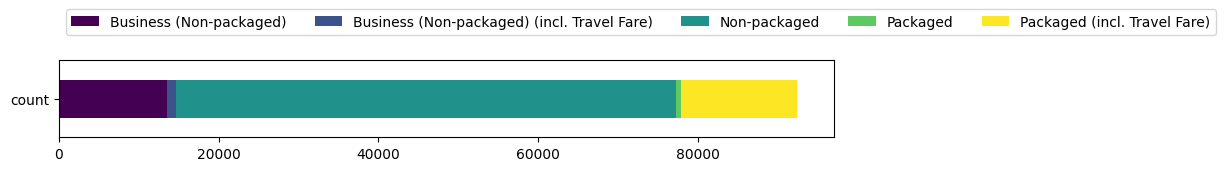

In [28]:
# purchased travel package

df['TRAVEL_PACKAGE'] = df['c1a'].fillna(0)
df['Package Type'] = df['tr.type'].fillna("").astype(str).map(label_map['tr.type'])
StackedHorizontalBar(df, 'TRAVEL_PACKAGE')

# package type = travel type x inclusion of travel fare

def PackageType(row):
    tr_type = row['Package Type']
    if row['Package Type']:
        if row['c2'] == 1:
            fare_type = " (incl. Travel Fare)"
        else:
            fare_type = ""
    return f"{tr_type}{fare_type}"

df['PACKAGE_TYPE'] = df.apply(PackageType, axis=1)
df['PACKAGE_TYPE'] = df['PACKAGE_TYPE'].astype(str)
StackedHorizontalBar(df, 'PACKAGE_TYPE')

In [29]:
# cost of travel package

df['$_PACKAGE_PER_PAX'] = df['c1b.r'].fillna(np.nan)

In [31]:
# accommodation
# - if no nights in package, fill with 0
# - if no nights in paid accommodation, fill with nights in package
# - if no nights in unpaid accommodation, fill with length of stay - nights in paid accommodation
# - if no specified pax, impute with 1 + total number of travel companions

df['NIGHTS_IN_PACKAGE'] = df['c1c'].fillna(0)
df['NIGHTS_IN_PAID_ACCOMMODATION'] = df['c4c_8'].fillna(df['NIGHTS_IN_PACKAGE'])
df['NIGHTS_IN_UNPAID_ACCOMMODATION'] = df['c4c_12'].fillna(df['LENGTH_OF_STAY'] - df['NIGHTS_IN_PAID_ACCOMMODATION'])

df['$_ACCOMMODATION_TOTAL'] = df[['c4d_1.r', 'c4d_2.r', 'c4d_3.r', 'c4d_4.r', 'c4d_5.r', 'c4d_6.r', 'c4d_7.r', 'c4d_8.r']].sum(axis=1)

total_companions = [
    'TRAVEL_COMPANION=SPOUSE',
    'TRAVEL_COMPANION=PARTNER',
    'N_PARENTS',
    'N_GRANDPARENTS',
    'N_SIBLINGS',
    'N_OTHER_RELATIVES',
    'N_FRIENDS',
    'N_OTHERS',
    'N_CHILDREN'
]
n_pax = df[total_companions].sum(axis=1) + 1
df['PAX_IN_ACCOMMODATION'] = df['c5'].fillna(n_pax)

In [32]:
# food & beverages
# - not in package unless declared
# - if no total spend, impute with sum of spend across all dining options
# - if no specified pax, impute with pax in accommodation

df['F&B_IN_PACKAGE'] = df['c6_1'].fillna(0)
df['F&B_HAWKER_IN_PACKAGE'] = df['c6b_1_1'].fillna(0)
df['F&B_CASUAL_IN_PACKAGE'] = df['c6b_2_1'].fillna(0)
df['F&B_FINE_IN_PACKAGE'] = df['c6b_3_1'].fillna(0)
df['F&B_OTHER_IN_PACKAGE'] = df['c6b_4_1'].fillna(0)

dining_map = {
    'c6c_1.r': '$_F&B_HAWKER',
    'c6c_2.r': '$_F&B_CASUAL',
    'c6c_3.r': '$_F&B_FINE',
    'c6c_4.r': '$_F&B_OTHER'
}
df.rename(columns = dining_map, inplace = True)
df['$_F&B_TOTAL'] = df['c6.tot'].fillna(df[['$_F&B_HAWKER','$_F&B_CASUAL','$_F&B_FINE','$_F&B_OTHER']].sum(axis=1))

df['PAX_DINING'] = df['c6d'].fillna(df['PAX_IN_ACCOMMODATION'])

In [33]:
# transportation
# - not in package unless declared
# - if no total spend, impute with sum of spend in vehicle and other
# - if no specified pax, impute with pax in accommodation

df['TRANSPORT_IN_PACKAGE'] = df['c7a_1'].fillna(0)

transport_map = {
    'c7b_1.r': '$_TRANSPORT_VEHICLE',
    'c7b_2.r': '$_TRANSPORT_OTHER',
}
df.rename(columns = transport_map, inplace = True)
df['$_TRANSPORT_TOTAL'] = df['c7.tot'].fillna(df[['$_TRANSPORT_VEHICLE','$_TRANSPORT_OTHER']].sum(axis=1))

df['PAX_TRANSPORT'] = df['c7c'].fillna(df['PAX_IN_ACCOMMODATION'])

In [35]:
# tour purchase method

method_map = {
    'c8ii_1': 'Pre-arrival Online',
    'c8ii_2': 'Post-arrival Online',
    'c8ii_4': 'Tour Desk',
    'c8ii_5': 'Hotel',
    'c8ii_6': 'Visitor Centre'
}

def PurchaseMethod(row):
    columns = list(method_map.keys())
    active_columns = [col for col in columns if row[col] == 1]
    if len(active_columns) == 1:
        return method_map[active_columns[0]]
    else:
        return 'Other'
    
df['TOUR_PURCHASE_METHOD'] = df.apply(PurchaseMethod, axis=1)

In [36]:
# friends/family in Singapore
# - no unless declared

df['FRIENDS_FAMILY_IN_SG'] = df['c9'].fillna(0)

In [ ]:
# sightseeing & entertainment

